# Task 1: Acquire, Preproess and Analyze Data


## Import libraries and data



In [2]:
import pandas as pd
pd.set_option('display.max_rows', 700)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GroupShuffleSplit

In [3]:
searchTrendData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv")
hospitalizationData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv")

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean the Dataframe

There are columns in the dataframe where the whole column contains nothing but NaN, 
so these columns need to be dropped. 

Then there are columns that contains a large
amount of NaNs. These should be dropped too once the amount of NaN reaches a certain
threshold. Several experimentation were performed to decide the best value for this
threshold. The higher the threshold, the more columns dropped. 

In [4]:
## drop all NaN columns for searchTrendData
searchTrendData = searchTrendData.dropna('columns', 'all')
## drop column if it doesn't have at least 60% of non-NaN values
searchTrendData = searchTrendData.dropna(axis = "columns", thresh = (int) (searchTrendData.shape[0] * 0.6))

## drop all data that is not from the US
hospitalizationData = hospitalizationData[hospitalizationData['open_covid_region_code'].str.contains('US-')]
## drop all NaN columns for hospitalizationData
hospitalizationData = hospitalizationData.dropna('columns', 'all')
## drop the column if it doesn't have at least 30% of non-Nan values 
hospitalizationData = hospitalizationData.dropna(axis = "columns", thresh = (int) (hospitalizationData.shape[0] * 0.3))

Merge two dataset

In [5]:
## debug cell, delete when assignment is finished
searchTrendData
len(searchTrendData[searchTrendData['open_covid_region_code'] == 'US-WY'])

39

In [6]:
# searchTrendData.iloc[7:10, :]

In [7]:
## debug cell, delete when assignment is finished
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')
## Feiyang Li --> Once you changed hospitalization data to weekly resolution, there are many duplicates. Let's drop them
## and see how it works
## 
hospitalizationData = hospitalizationData.drop_duplicates();
hospitalizationData

,open_covid_region_code,region_name,date,hospitalized_new,hospitalized_cumulative
85278,US-WY,Wyoming,2020-03-02,0.0,0.0
85280,US-WY,Wyoming,2020-03-09,0.0,0.0
85287,US-WY,Wyoming,2020-03-16,0.0,0.0
85294,US-WY,Wyoming,2020-03-23,0.0,0.0
85298,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
97499,US-AK,Alaska,2020-09-07,0.0,0.0
97506,US-AK,Alaska,2020-09-14,0.0,0.0
97513,US-AK,Alaska,2020-09-21,0.0,0.0
97520,US-AK,Alaska,2020-09-28,0.0,0.0


In [8]:
hospitalizationData
# len(hospitalizationData[hospitalizationData['open_covid_region_code'] == 'US-WY'])

,open_covid_region_code,region_name,date,hospitalized_new,hospitalized_cumulative
85278,US-WY,Wyoming,2020-03-02,0.0,0.0
85280,US-WY,Wyoming,2020-03-09,0.0,0.0
85287,US-WY,Wyoming,2020-03-16,0.0,0.0
85294,US-WY,Wyoming,2020-03-23,0.0,0.0
85298,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
97499,US-AK,Alaska,2020-09-07,0.0,0.0
97506,US-AK,Alaska,2020-09-14,0.0,0.0
97513,US-AK,Alaska,2020-09-21,0.0,0.0
97520,US-AK,Alaska,2020-09-28,0.0,0.0


In [9]:
## change dates to weekly represented dates
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')

## drop the hospitalized_culumative column since it doesn't make since to merge them into a weekly entry
hospitalizationData = hospitalizationData.drop('hospitalized_cumulative', axis = 1)

## combine all data with the same region code, and the same date
## find all unique dates and regions
region_codes = hospitalizationData['open_covid_region_code'].unique()

result_df = pd.DataFrame()
## group all rows with the same region code
for code in region_codes:
    region_rows = hospitalizationData.groupby(['open_covid_region_code']).get_group(code)
    ## group these rows again by dates
    dates = region_rows['date'].unique()
    for date in dates:
        region_data = region_rows.groupby('date').get_group(date)

        ## combine all these entries into one row additively
        result_row = region_data.head(1)
        for r in range(1, region_data.shape[0]):
            for i in range(3, result_row.shape[1]):
                current_column = result_row.columns[i]
                result_row[current_column] += region_data.iloc[r][current_column]
        result_df = result_df.append(result_row)
    print(result_row)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      open_covid_region_code region_name       date  hospitalized_new
85490                  US-WY     Wyoming 2020-10-05              31.0
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      open_covid_region_code    region_name       date  hospitalized_new
85707                  US-WV  West Virginia 2020-10-05               0.0
/opt/venv/

In [10]:
result_df.reset_index(inplace = True)
result_df


,index,open_covid_region_code,region_name,date,hospitalized_new
0,85278,US-WY,Wyoming,2020-03-02,0.0
1,85280,US-WY,Wyoming,2020-03-09,0.0
2,85287,US-WY,Wyoming,2020-03-16,0.0
3,85294,US-WY,Wyoming,2020-03-23,15.0
4,85301,US-WY,Wyoming,2020-03-30,8.0
...,...,...,...,...,...
1795,97499,US-AK,Alaska,2020-09-07,0.0
1796,97506,US-AK,Alaska,2020-09-14,0.0
1797,97513,US-AK,Alaska,2020-09-21,0.0
1798,97520,US-AK,Alaska,2020-09-28,0.0


In [11]:
## this should merge two dataframe without duplicates
searchTrendData['date'] = pd.to_datetime(searchTrendData['date'])
result_df['date'] = pd.to_datetime(result_df['date'])
mergedData = searchTrendData.merge(result_df, on = ['open_covid_region_code', 'date'], how = 'left');
mergedData
#do we want to do outer merge or do we want to do inner join based on date and open_covid_region_code

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,index,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,8.33,...,NaN,13.68,NaN,10.31,NaN,9.91,NaN,NaN,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,8.22,...,8.41,NaN,NaN,15.49,7.65,8.41,NaN,NaN,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,8.28,...,7.91,13.98,NaN,14.90,7.54,16.19,NaN,NaN,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,7.47,7.65,NaN,10.39,...,9.66,10.20,NaN,15.12,NaN,NaN,NaN,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,8.06,12.56,7.50,10.31,...,NaN,10.50,NaN,11.43,NaN,10.68,10.50,NaN,NaN,NaN
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,10.88,NaN,11.43,...,13.60,8.89,7.62,12.88,7.44,NaN,7.80,NaN,NaN,NaN
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,9.16,NaN,9.16,...,8.14,7.29,NaN,12.72,NaN,8.65,8.48,NaN,NaN,NaN
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,10.61,7.29,NaN,8.95,...,10.61,9.94,NaN,9.28,7.13,8.62,11.10,NaN,NaN,NaN
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,6.64,NaN,...,8.14,6.98,NaN,12.46,NaN,10.46,14.12,97314.0,Alaska,0.0
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,7.91,NaN,NaN,...,7.07,8.58,8.08,13.97,NaN,NaN,18.85,97317.0,Alaska,0.0


In [12]:
# for region in mergedData['open_covid_region_code'].unique():
#     print(mergedData[mergedData['open_covid_region_code'] == region].shape)



(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)
(39, 24)


# Task 2: Visualize and cluster the data

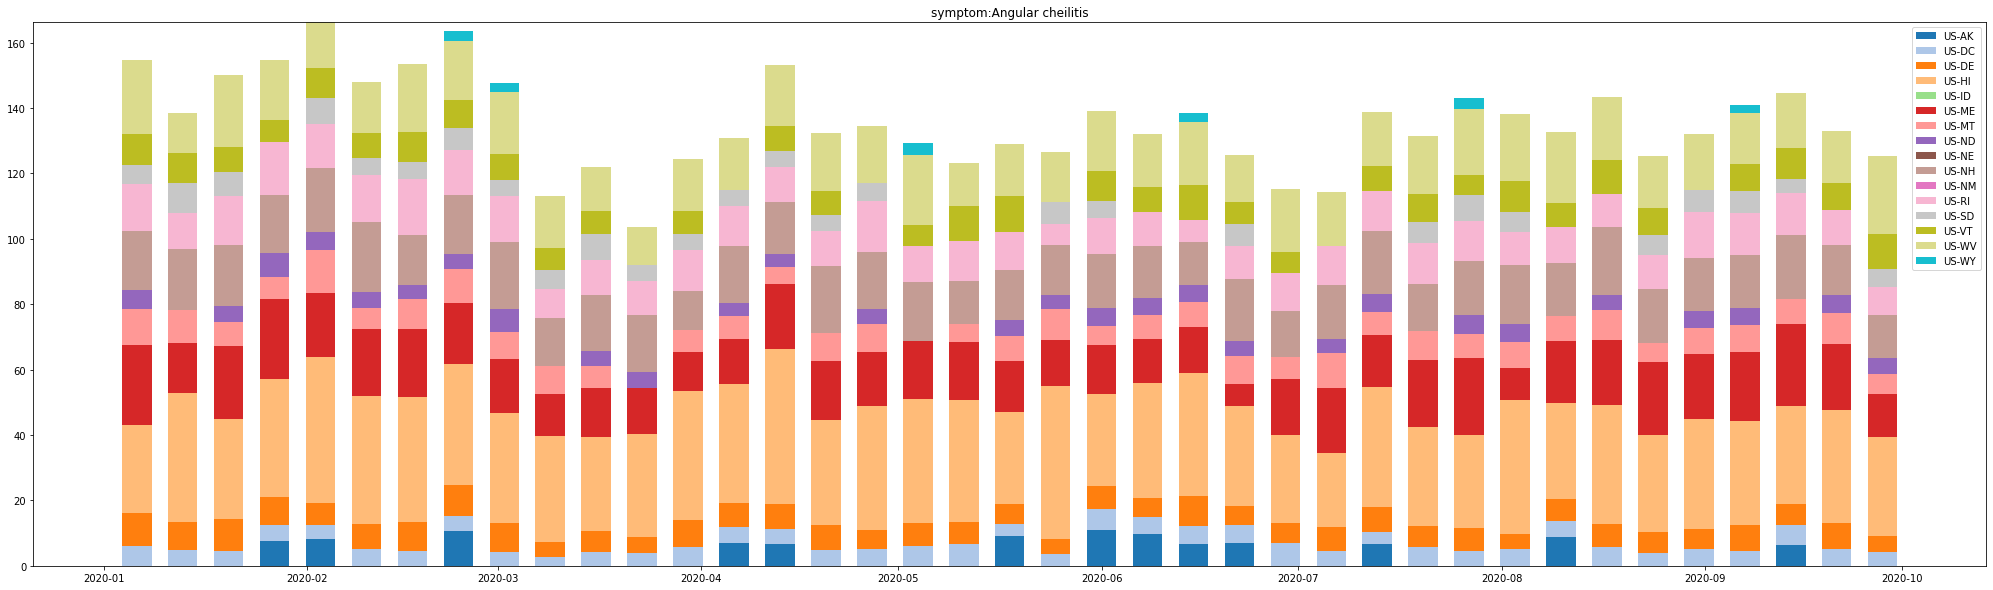

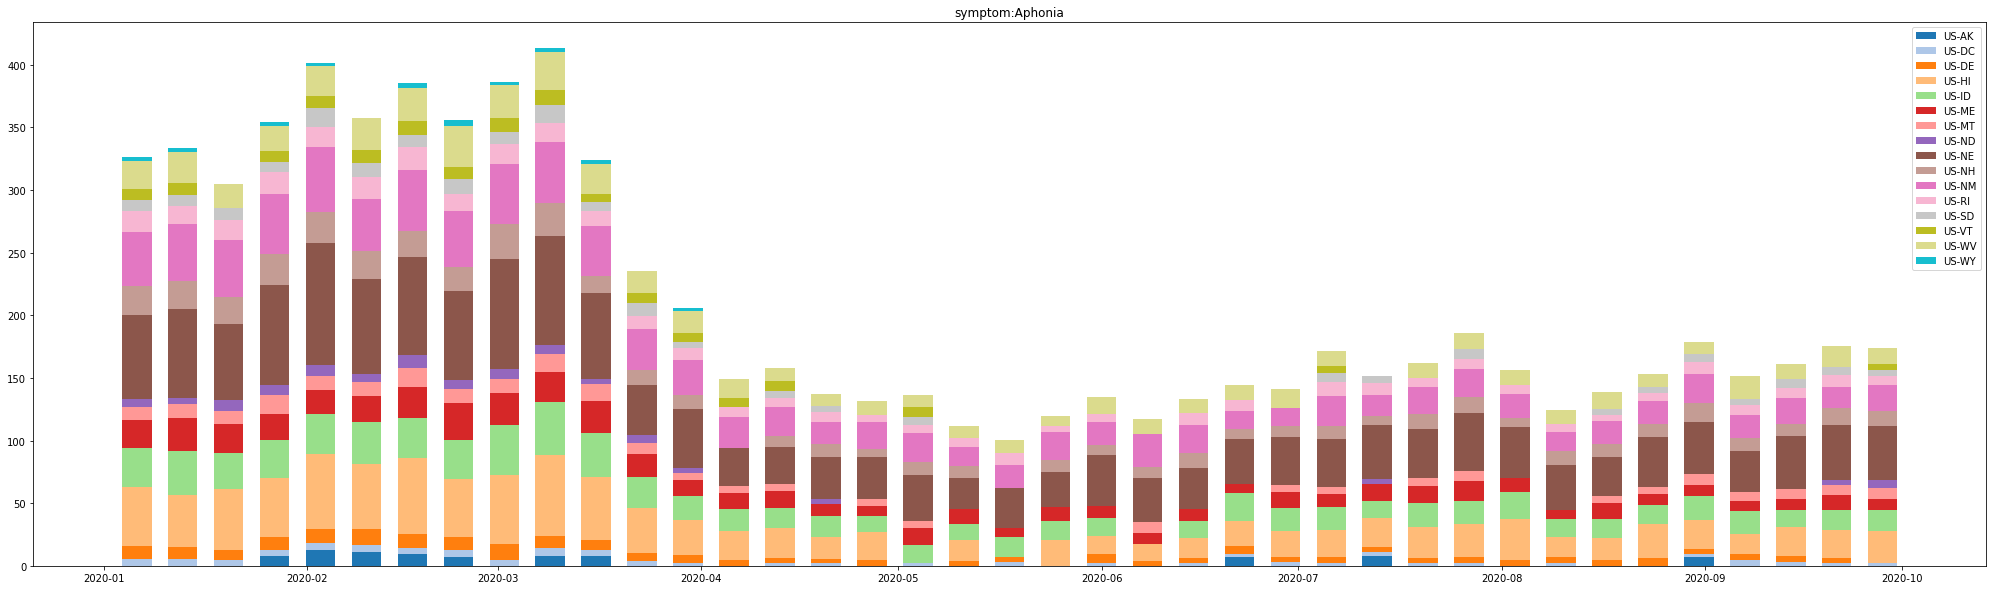

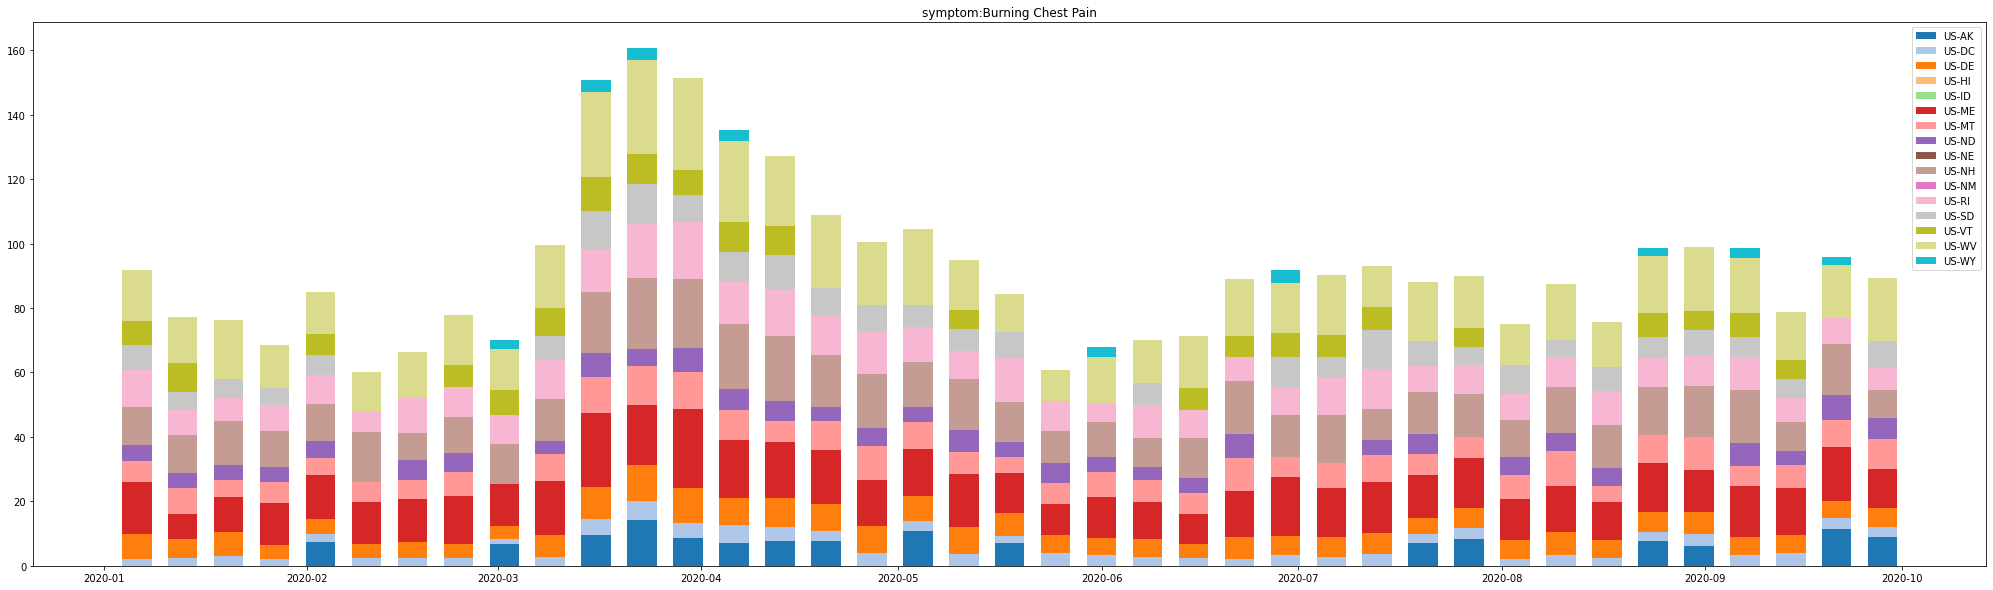

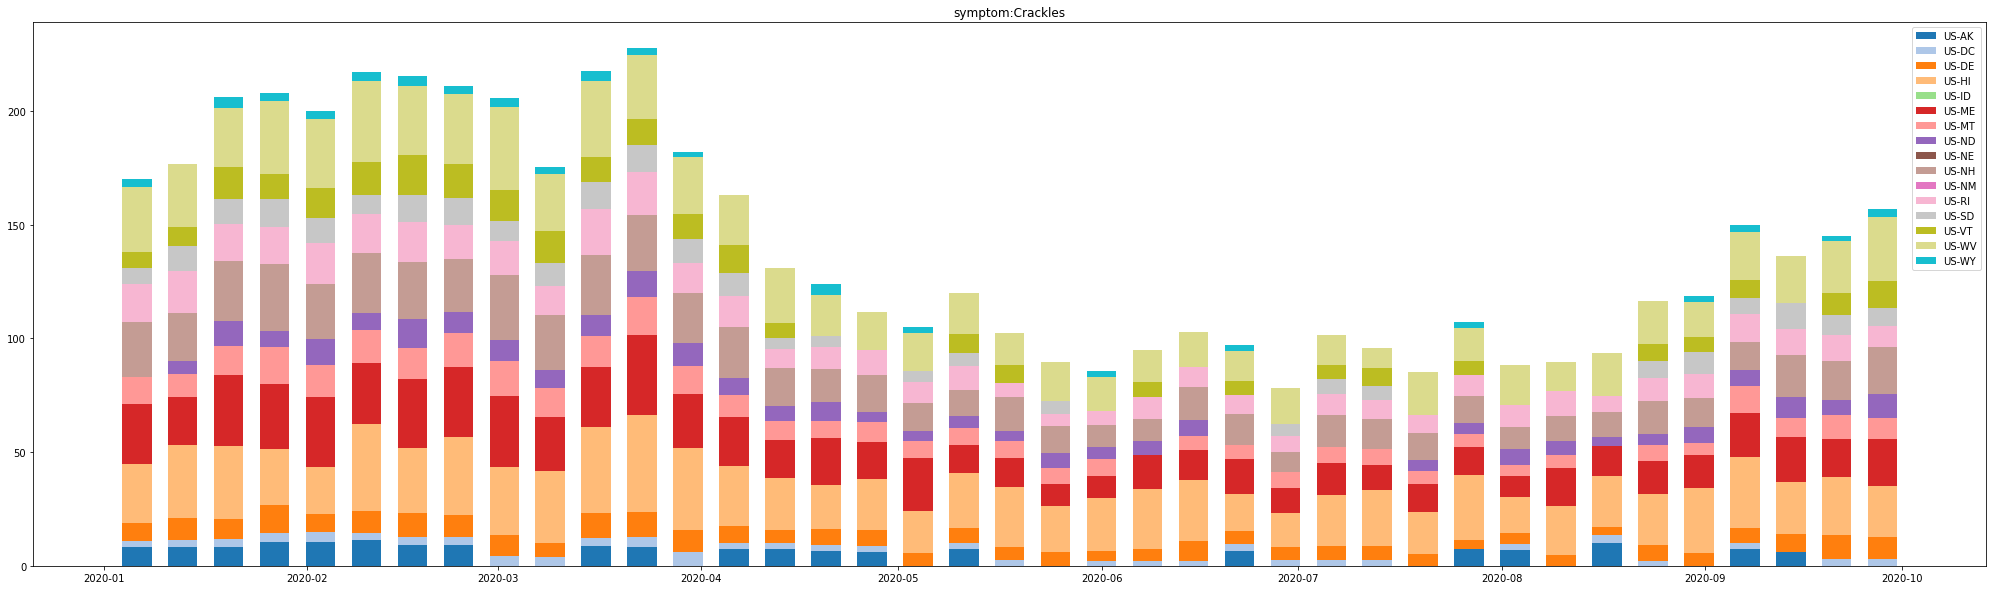

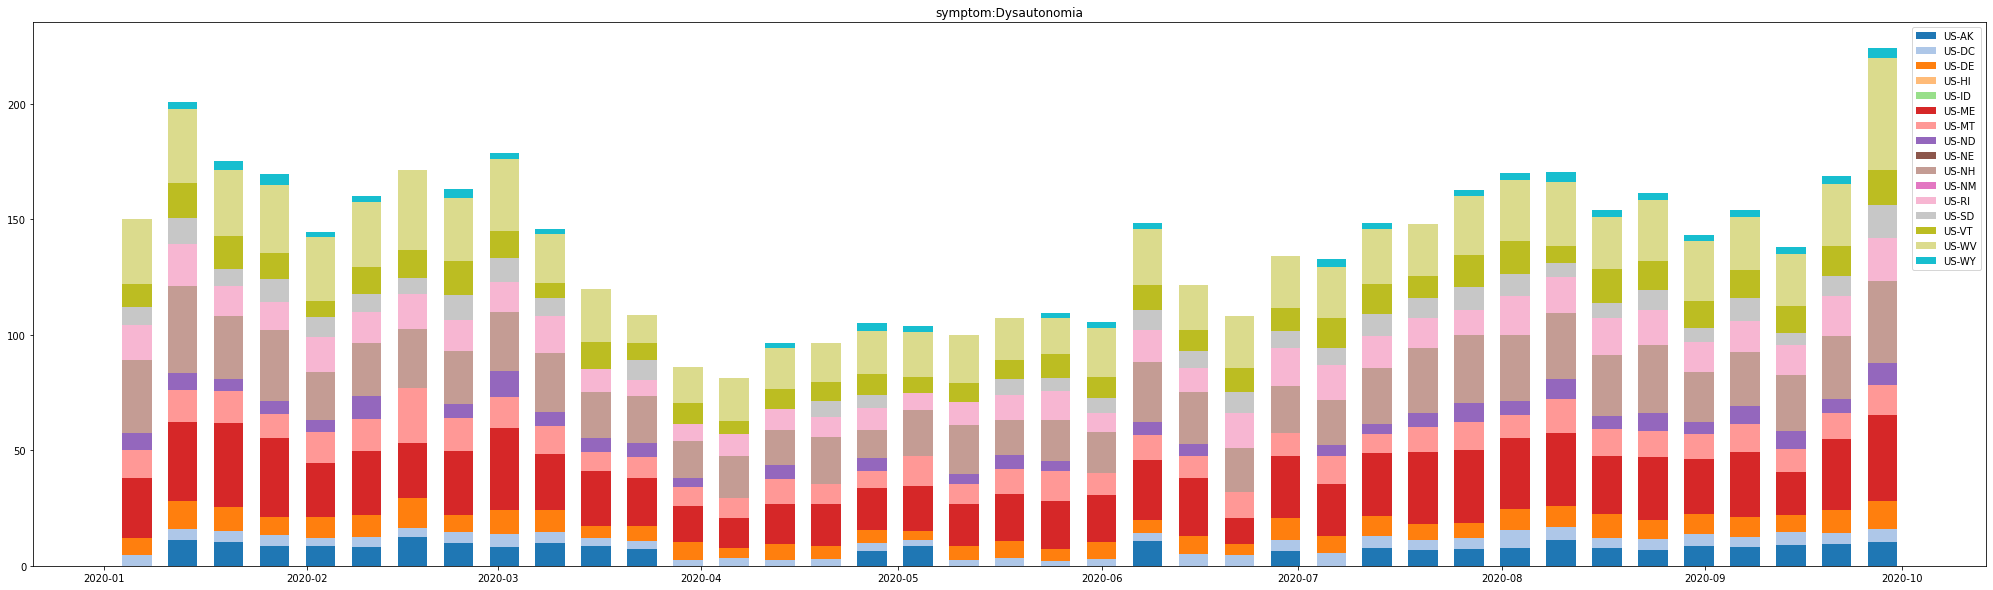

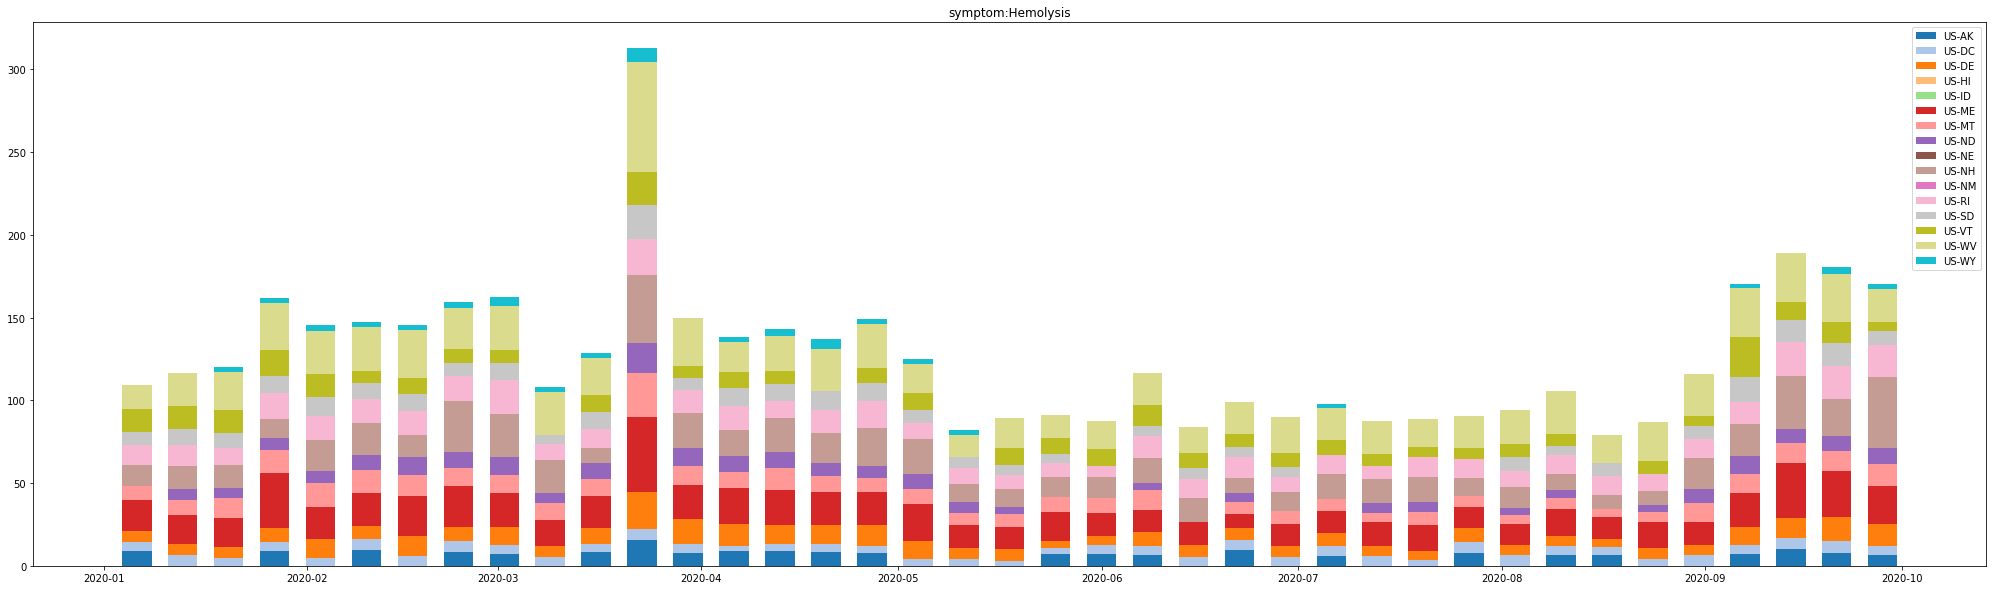

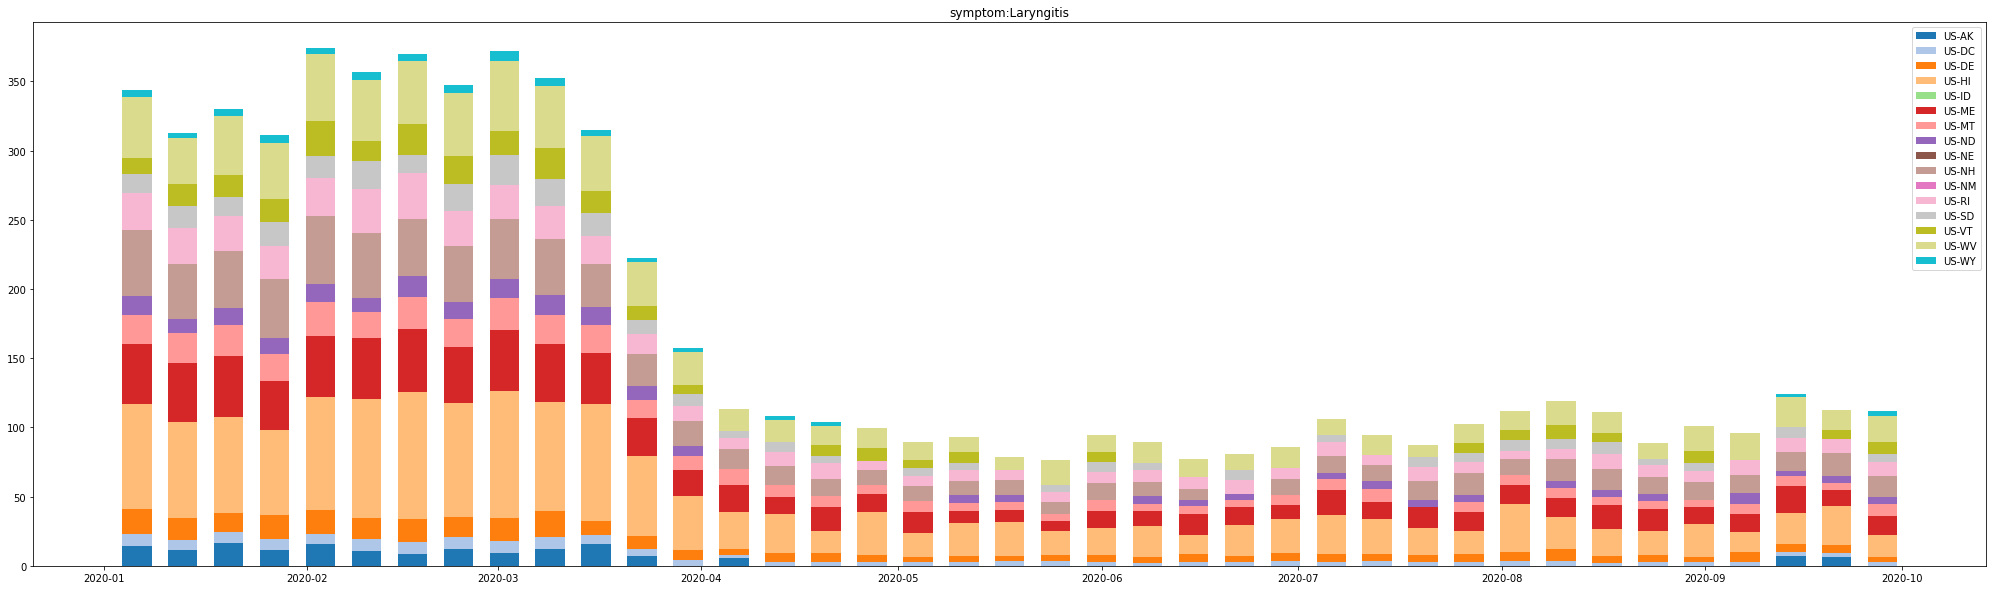

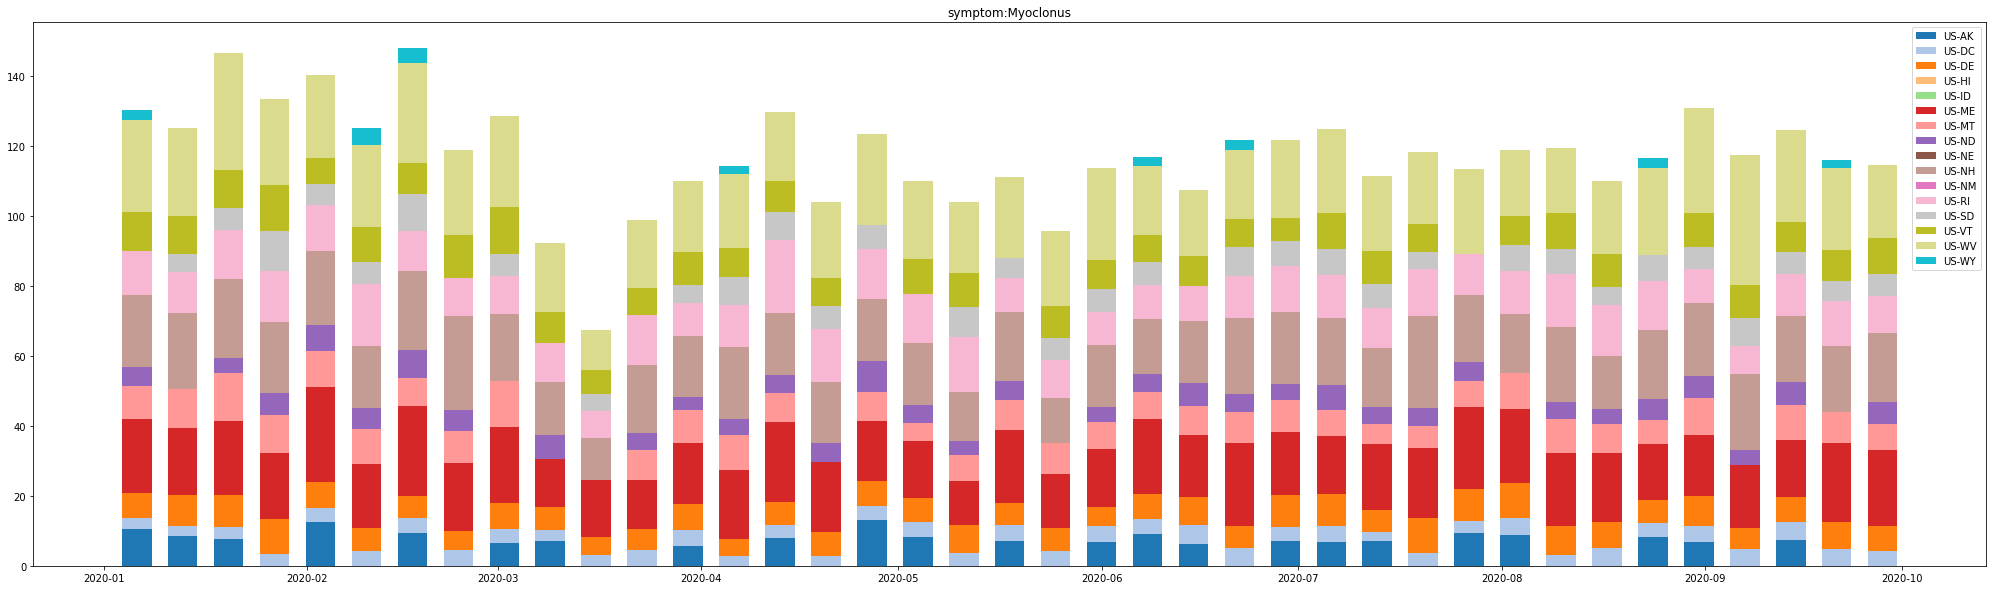

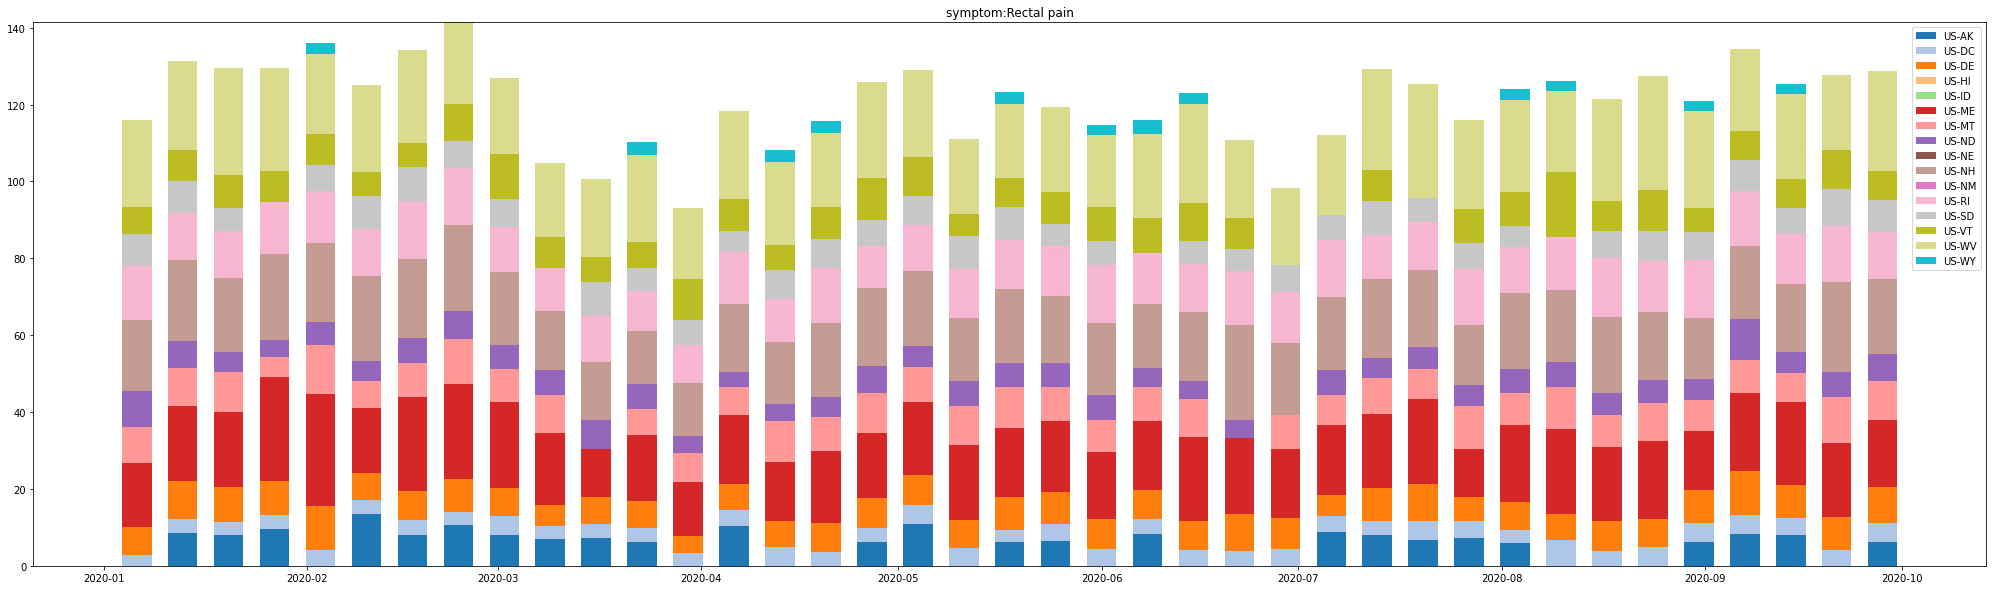

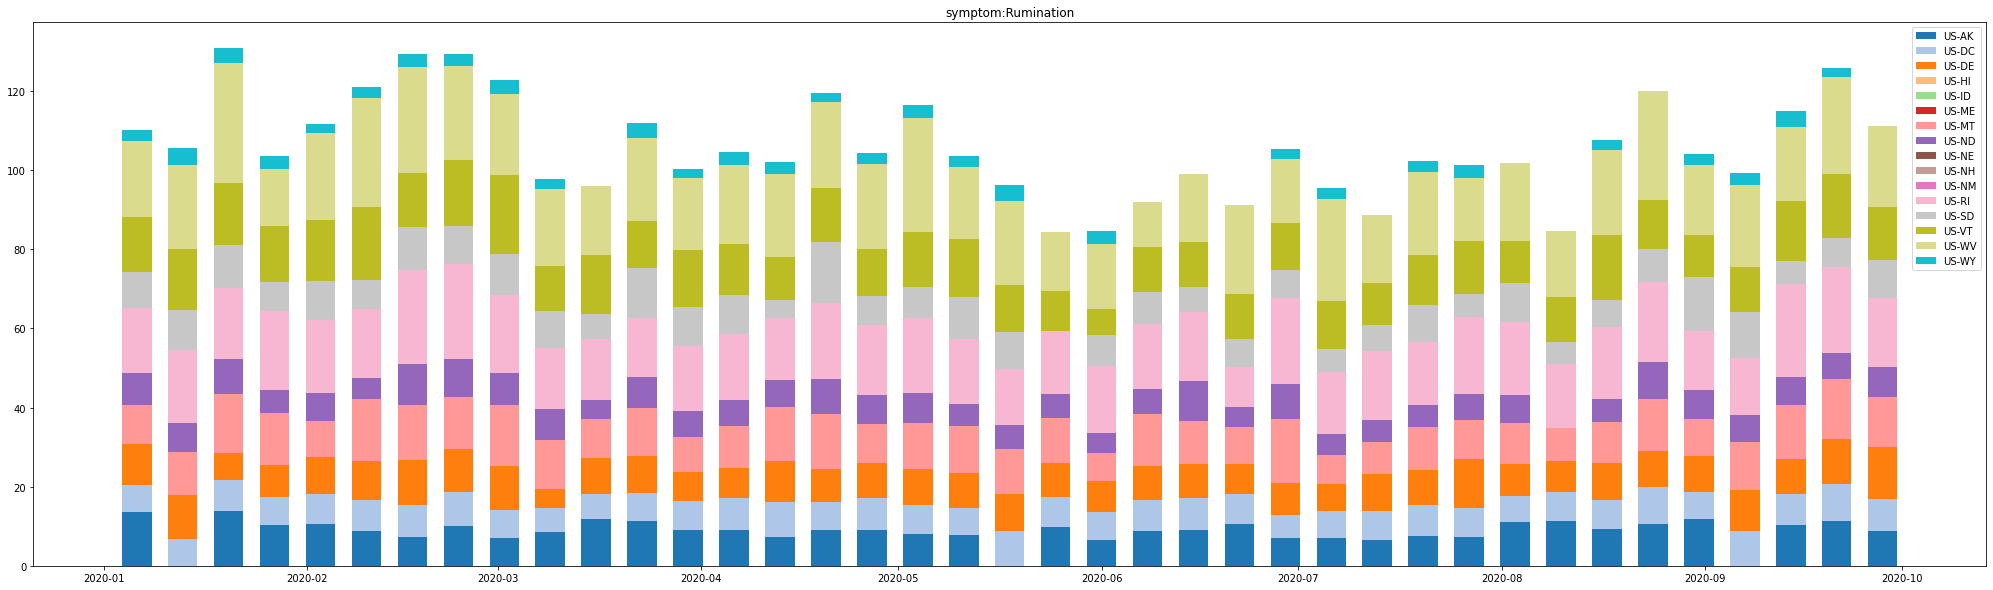

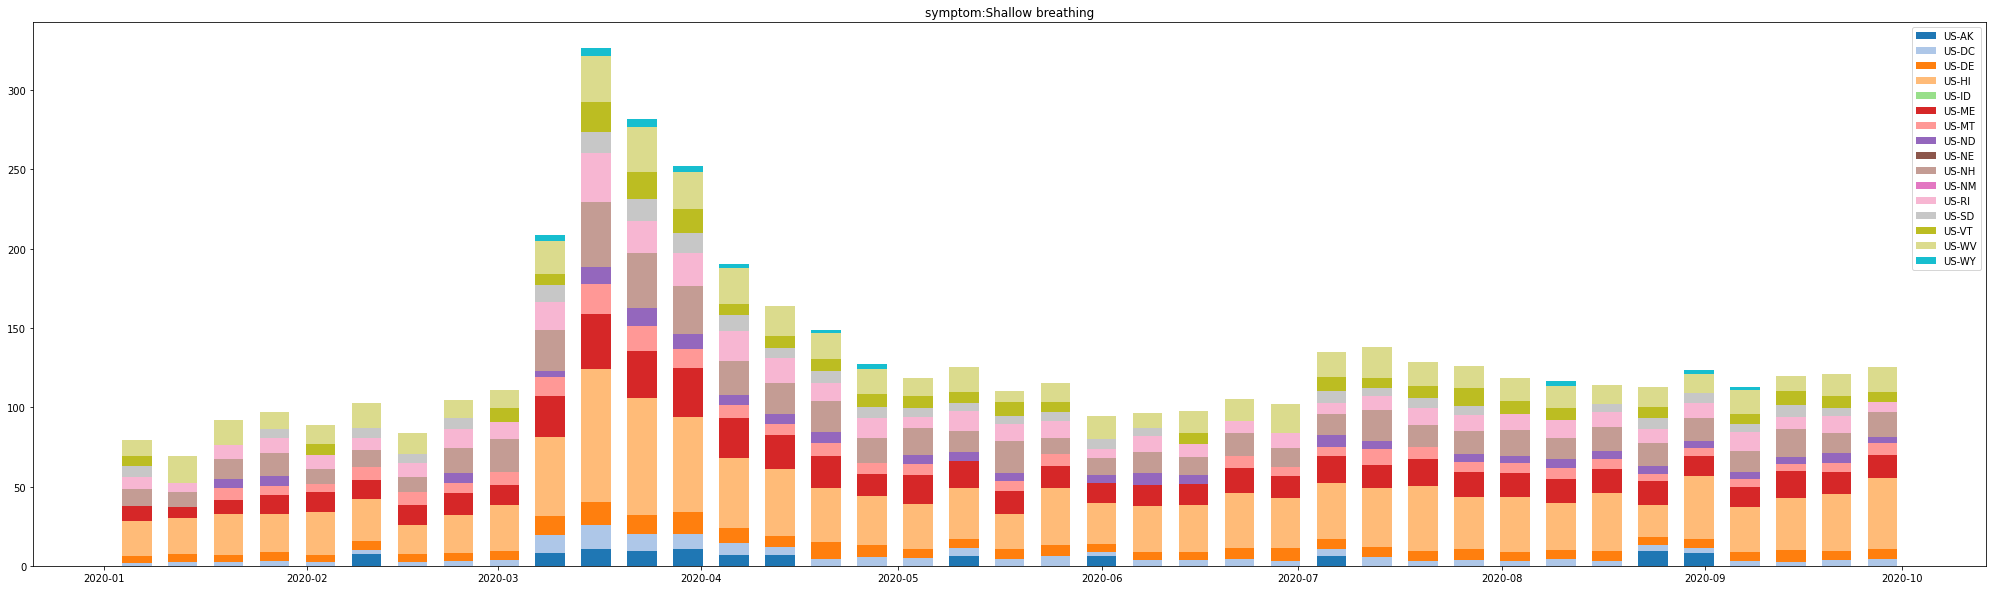

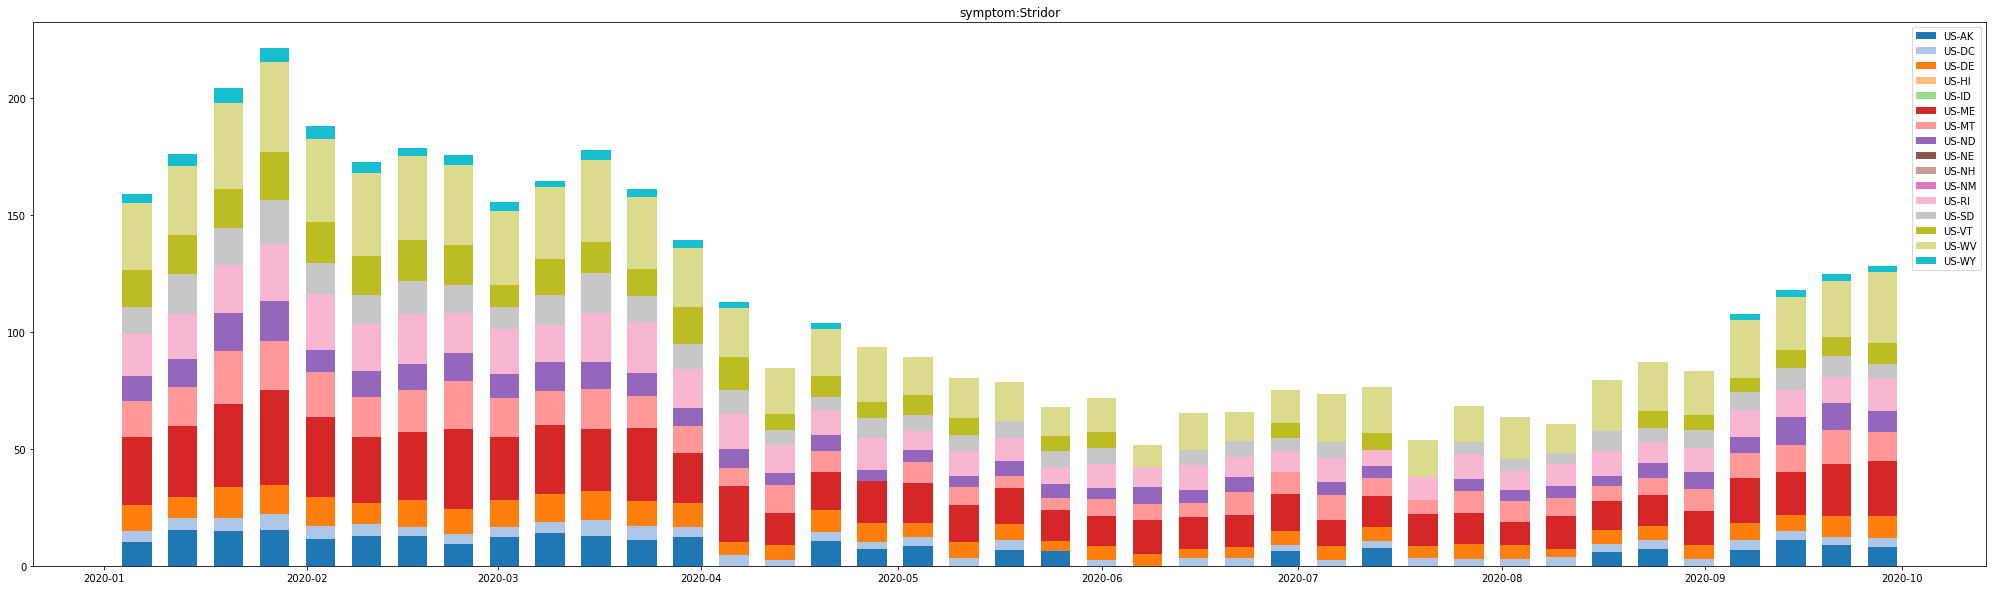

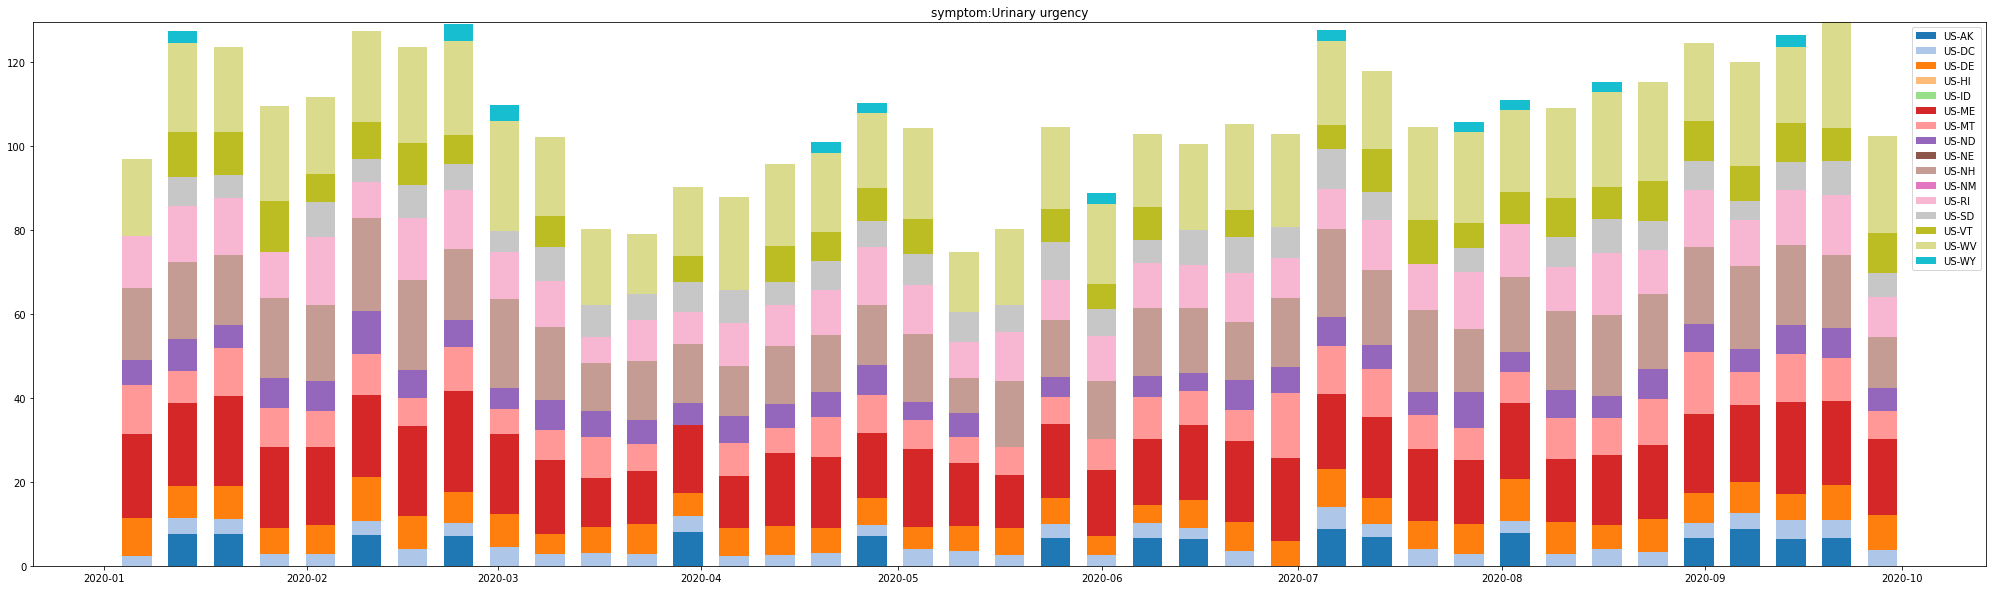

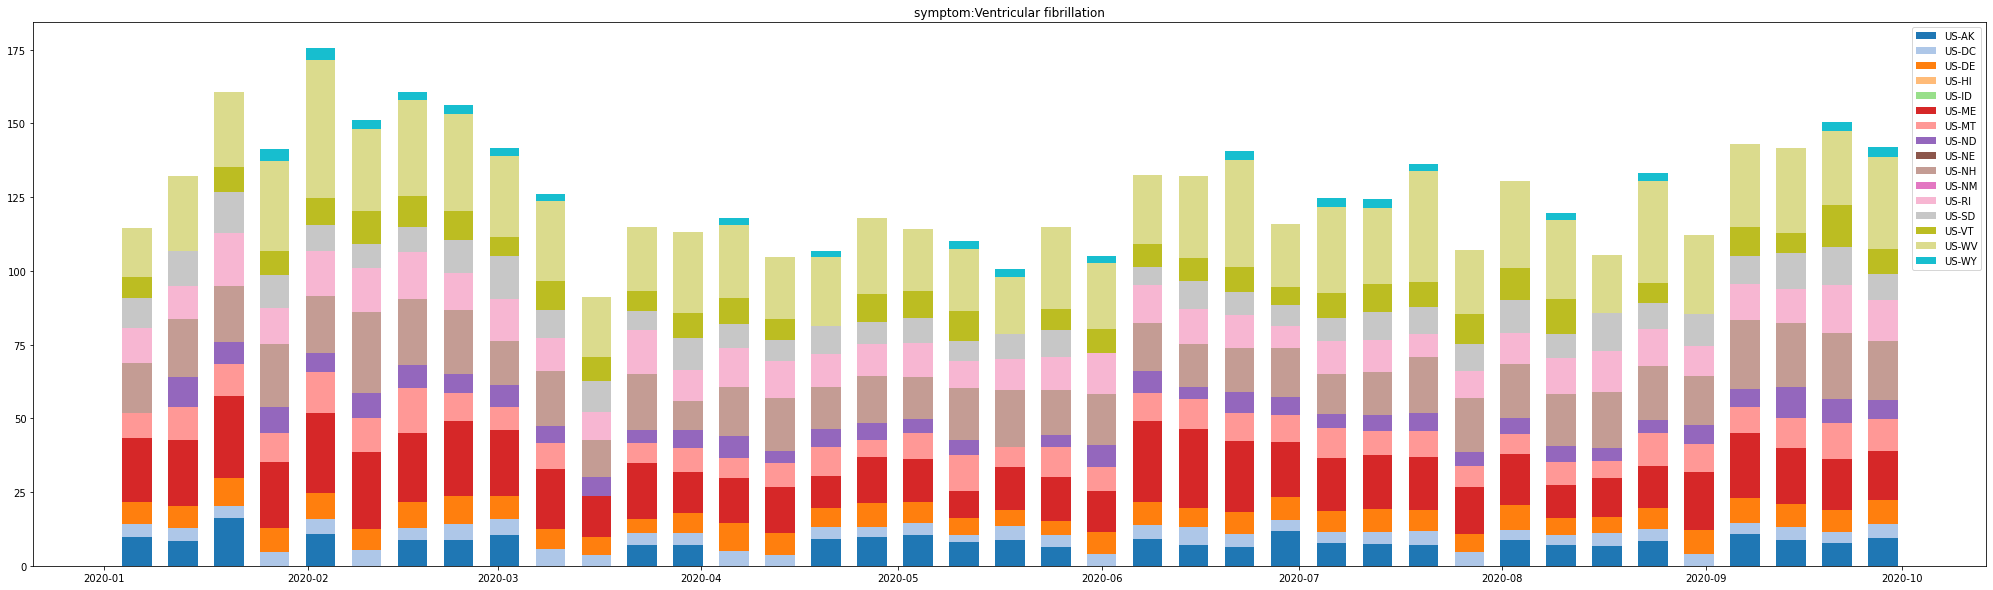

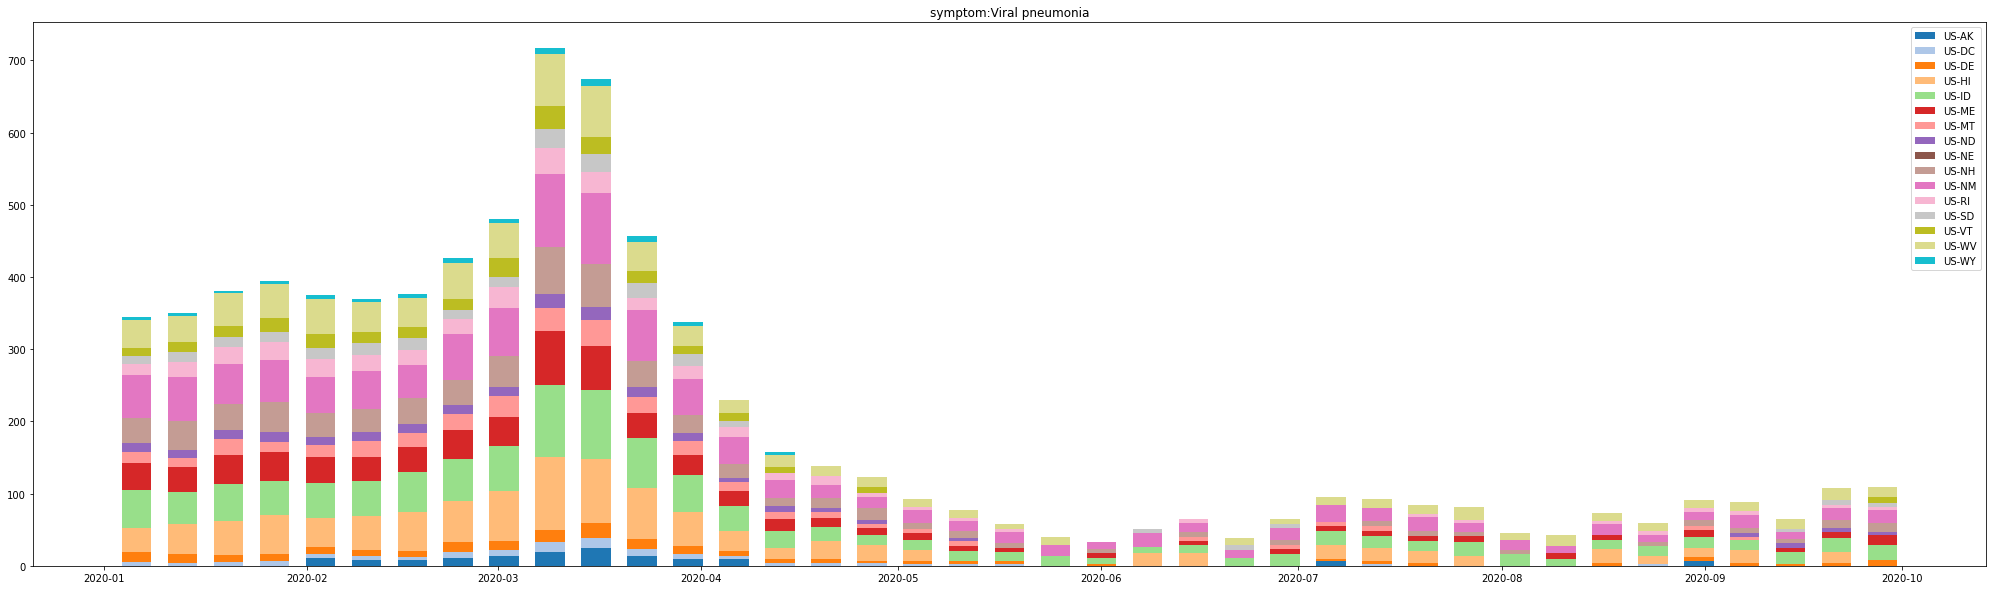

In [16]:
## extract all symptoms
symptoms = []
for column in mergedData.columns:
    type(column)
    if 'symptom' in column:
        ## column = column[8:]
        symptoms.append(column)

del column

## iteratively plot each symptoms
weeks = mergedData['date'].unique()
regions = mergedData['open_covid_region_code'].unique()
grouped_data_by_week = mergedData.groupby('date')
grouped_by_region = mergedData.groupby('open_covid_region_code')

## for each symptom, draw a graph
for symptom in symptoms:
    fig, ax = plt.subplots(figsize=(35, 10))
    NUM_COLORS = len(regions)
    color_map = plt.get_cmap('tab20')
    ax.set_prop_cycle('color', [color_map(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    width = 4.5
    ## for each region, fetch data from each week
    previous_region_week_data = [0] * len(weeks) ## the bottom for the next region rect
    for region in regions:
        region_data_all_weeks = grouped_by_region.get_group(region)[symptom].fillna(0)
        ax.set_title(symptom)
        ax.bar(weeks, region_data_all_weeks, width, previous_region_week_data, label = region)
        ax.legend()
        ## update previous data
        region_data_list =region_data_all_weeks.to_list()
        for i in range(0, len(region_data_all_weeks)):
            previous_region_week_data[i] += region_data_list[i]

del symptoms
del weeks
del regions
del grouped_data_by_week

### PRINCIPAL COMPONENT ANALYSIS (PCA)

In [17]:
## OneHotEncoding and dealing with nan values

searchTrendDataCopy = searchTrendData.copy()  #making a copy of searchTrendData to avoid potential alterations on the main data
# searchTrendDataPCA.dtypes    #just to know the data-types so we know which ones to one_hot e
#print(searchTrendDataCopy.shape)
features_to_be_encoded = searchTrendDataCopy.select_dtypes(exclude = ['float64'])
#print(pd.DataFrame(features_to_be_encoded).isnull().values.any())
encoder = OneHotEncoder(sparse = False)
train = encoder.fit(features_to_be_encoded) 
# print(train.categories_)  #you can uncomment this to view the unique values per feature
encoded_features = encoder.transform(features_to_be_encoded)

# joining the encoded_features to the rest of the data
encoded_features = pd.DataFrame(encoded_features)
searchTrendDataEncoded = encoded_features.join(searchTrendDataCopy.iloc[:,6:])
print(searchTrendDataEncoded.shape)

# Before using PCA, lets'replace nan values with the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')  # we can change the strategy to median or most frequent also.
imp.fit(searchTrendDataEncoded)
#print(imp.statistics_)
searchTrendDataEncoded = imp.transform(searchTrendDataEncoded)
#print(searchTrendDataEncoded.shape)
#print(pd.DataFrame(searchTrendDataEncoded).isnull().values.any())

(624, 104)


Text(0, 0.5, 'second principal direction')

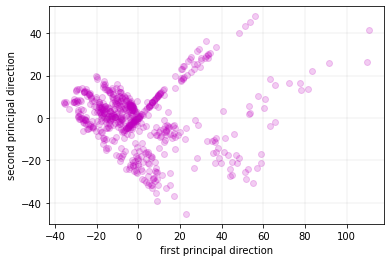

In [18]:
# PCA using scikit-learn
pca = PCA(n_components=2)

searchTrendDataPCA = pca.fit_transform(searchTrendDataEncoded)
## pca.components_.T[:,:2]
## print(pca.explained_variance_ratio_)

# Lets see what we have now
plt.scatter(searchTrendDataPCA[:,0], searchTrendDataPCA[:,1], alpha=0.2, c = 'm' )
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.xlabel("first principal direction")
plt.ylabel("second principal direction")

### K - Means Clustering

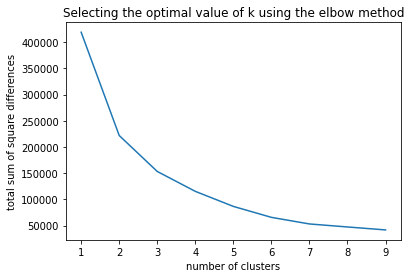

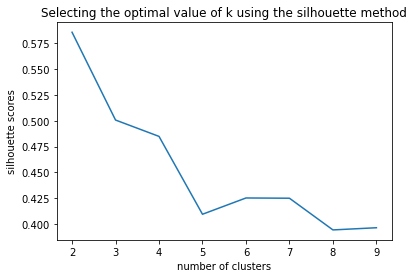

In [19]:
## K-Means on searchTrendDataPCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#print(searchTrendDataPCA.shape)

inertia_values = []
sil_scores = []

for val in range(1,10):
    kmeans = KMeans(n_clusters = val, n_init = 30, init = 'k-means++')
    kmeans.fit(searchTrendDataPCA)
    inertia_values.append(kmeans.inertia_)
    if val >= 2:
        sil_scores.append(silhouette_score(searchTrendDataPCA, kmeans.labels_))

plt.plot(range(1,10), inertia_values)
plt.title('Selecting the optimal value of k using the elbow method')
plt.xlabel('number of clusters')
plt.ylabel('total sum of square differences')
plt.show()

plt.figure()
plt.plot(range(2,10), sil_scores)
plt.title('Selecting the optimal value of k using the silhouette method')
plt.xlabel('number of clusters')
plt.ylabel('silhouette scores')
plt.show()

In [20]:
# choose 2 based on the silhouette and the elbow method
kmeans = KMeans(n_clusters = 2, n_init = 30, init = 'k-means++')
prediction = kmeans.fit_predict(searchTrendDataPCA)

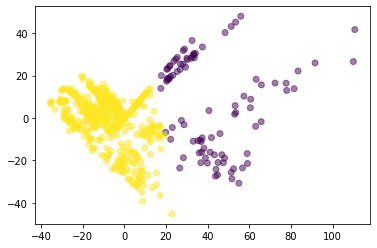

In [21]:
plt.scatter(searchTrendDataPCA[:,0], searchTrendDataPCA[:,1], c=prediction, alpha=0.5)

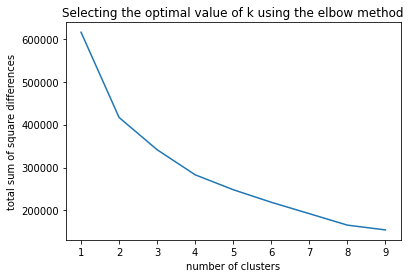

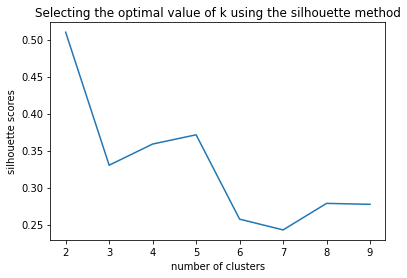

In [22]:
## K-Means on raw data

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#print(searchTrendDataPCA.shape)

inertia_values = []
sil_scores = []

for val in range(1,10):
    kmeans = KMeans(n_clusters = val, n_init = 30, init = 'k-means++')
    kmeans.fit(searchTrendDataEncoded)
    inertia_values.append(kmeans.inertia_)
    if val >= 2:
        sil_scores.append(silhouette_score(searchTrendDataEncoded, kmeans.labels_))

plt.plot(range(1,10), inertia_values)
plt.title('Selecting the optimal value of k using the elbow method')
plt.xlabel('number of clusters')
plt.ylabel('total sum of square differences')
plt.show()

plt.figure()
plt.plot(range(2,10), sil_scores)
plt.title('Selecting the optimal value of k using the silhouette method')
plt.xlabel('number of clusters')
plt.ylabel('silhouette scores')
plt.show()

# Task 3: Supervised Learning

## 1. Splitting the data into train and validation based on time or based on regions

In [23]:
## a function that splits the dataset into 80% training set and 20% validation set
def split_dataset_on(dataset, on):
    gss = GroupShuffleSplit(n_splits = 2, train_size = 0.8)
    training, validation = next(gss.split(dataset, groups = mergedData[on]))
    training_set = mergedData.loc[training]
    validation_set = mergedData.loc[validation]
    return training_set, validation_set

training_set_region, validation_set_region = split_dataset_on(mergedData, 'open_covid_region_code')
training_set_time, validation_set_time = split_dataset_on(mergedData, 'date')

## 2. Regression performance comparison between KNNs and Decision Trees

DECISION TREES

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [25]:
# I don't think we need the 'index' and 'region_name' columns from the hospitalization dataset in the mergedData
# LFY: Feel free to drop them if you want
data = mergedData.drop(['index', 'region_name'], axis=1)

## since hospitalized_new is our target, we take regions with valid entries in hospitalized_new.
data = data[data['hospitalized_new'].notna()]



#### KNN

##### KNN - region

RMSE value for k =  1 is: 87.92204339234681
RMSE value for k =  2 is: 68.40104078851711
RMSE value for k =  3 is: 48.990226862531756
RMSE value for k =  4 is: 42.34063257282143
RMSE value for k =  5 is: 40.6302491114335
RMSE value for k =  6 is: 38.35972176604327
RMSE value for k =  7 is: 36.95704437927498
RMSE value for k =  8 is: 34.812027119127336
RMSE value for k =  9 is: 32.44688147692926
RMSE value for k =  10 is: 35.15690002044576
RMSE value for k =  11 is: 35.138428673152994
RMSE value for k =  12 is: 40.12429019959312
RMSE value for k =  13 is: 38.97259370399802
RMSE value for k =  14 is: 40.70839854799105
RMSE value for k =  15 is: 42.20315442459537
RMSE value for k =  16 is: 43.75804135282696
RMSE value for k =  17 is: 46.545341074543565
RMSE value for k =  18 is: 46.72925382290397
RMSE value for k =  19 is: 50.276406552153155
RMSE value for k =  20 is: 53.0698181195121


Text(0, 0.5, 'RMSE')

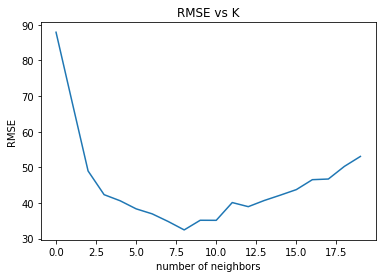

In [124]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt

training_set_region_clean   = training_set_region.dropna()
validation_set_region_clean = validation_set_region.dropna()

training_set_region_clean   =   training_set_region_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)
validation_set_region_clean = validation_set_region_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)

X = list(training_set_region_clean.columns)
X.remove('hospitalized_new')
y = ['hospitalized_new']
rmse_val = []

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(training_set_region_clean[X], training_set_region_clean[y])
    result = model.predict(validation_set_region_clean[X])
    error = sqrt(mean_squared_error(validation_set_region_clean[y],result))
    rmse_val.append(error)
    print('RMSE value for k = ',K,'is:',error)

curve = pd.DataFrame(rmse_val)
plt = curve.plot(title = 'RMSE vs K (region)',legend=False)
plt.set_xlabel('number of neighbors')
plt.set_ylabel('RMSE')

##### KNN - time

RMSE value for k =  1 is: 66.47054485509602
RMSE value for k =  2 is: 64.81885013893206
RMSE value for k =  3 is: 81.70942191467046
RMSE value for k =  4 is: 76.29438598831065
RMSE value for k =  5 is: 72.81899019715485
RMSE value for k =  6 is: 74.1141511953514
RMSE value for k =  7 is: 66.31540796325793
RMSE value for k =  8 is: 51.8723292485181
RMSE value for k =  9 is: 57.238868488498454
RMSE value for k =  10 is: 57.1695898183641
RMSE value for k =  11 is: 57.137440022647134
RMSE value for k =  12 is: 57.82818580998433
RMSE value for k =  13 is: 58.77174783171984
RMSE value for k =  14 is: 60.12502280537562
RMSE value for k =  15 is: 59.93173647606948
RMSE value for k =  16 is: 60.69877598642332
RMSE value for k =  17 is: 61.74026967590909
RMSE value for k =  18 is: 62.88487914189991
RMSE value for k =  19 is: 63.49344343463695
RMSE value for k =  20 is: 64.95274949274022


Text(0, 0.5, 'RMSE')

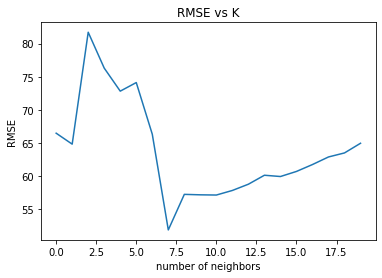

In [125]:
training_set_time_clean   = training_set_time.dropna()
validation_set_time_clean = validation_set_time.dropna()

training_set_time_clean   =   training_set_time_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)
validation_set_time_clean = validation_set_time_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)

X = list(training_set_time_clean.columns)
X.remove('hospitalized_new')
y = ['hospitalized_new']
rmse_val = []

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(training_set_time_clean[X], training_set_time_clean[y])
    result = model.predict(validation_set_time_clean[X])
    error = sqrt(mean_squared_error(validation_set_time_clean[y],result))
    rmse_val.append(error)
    print('RMSE value for k = ',K,'is:',error)

curve = pd.DataFrame(rmse_val)
plt = curve.plot(title = 'RMSE vs K (time)',legend=False)
plt.set_xlabel('number of neighbors')
plt.set_ylabel('RMSE')

#### Decision Tree - region - unsure

TypeError: object of type 'float' has no len()

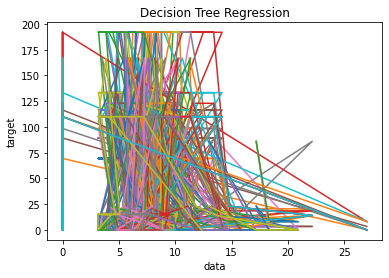

In [143]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")


for d in range(10):
    d = d + 1
    clf = tree.DecisionTreeRegressor(max_depth=d)
    clf = clf.fit(training_set_region_clean[X], training_set_region_clean[y])

    result = clf.predict(validation_set_region_clean[X])

    plt.plot(validation_set_region_clean,result,label='max depth: '+str(i),)    

#adjust tick size
# plt.xticks(0.5)
plt.show()
    